In [56]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
from sklearn.decomposition import PCA
from baseline.raif_hack.metrics import deviation_metric
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

In [57]:
DATA_DIR = 'data'
FILENAME = 'train.csv'

In [58]:
df = pd.read_csv(os.path.join(DATA_DIR, FILENAME))

C:\Users\Konstantin\.virtualenvs\bd_ml_itmo-1eel-7OV\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [59]:
df.head()

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [60]:
# Отбросить признаки с большим числом пропусков
print((df.isna().astype(int).sum(0) / df.shape[0]).sort_values()[-10:])

features_to_drop = ['floor', 'id', ]  # 'date'
df = df[[c for c in df.columns if c not in features_to_drop]]

price_type                        0.000000
osm_city_nearest_population       0.000197
street                            0.005740
reform_house_population_1000      0.052167
reform_mean_year_building_1000    0.058040
reform_mean_floor_count_1000      0.059716
reform_house_population_500       0.097337
reform_mean_year_building_500     0.105925
reform_mean_floor_count_500       0.107823
floor                             0.629886
dtype: float64


In [17]:
profile = pandas_profiling.ProfileReport(df, title='Profile report', minimal=True)

C:\Users\Konstantin\.virtualenvs\bd_ml_itmo-1eel-7OV\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [18]:
# profile.to_file("output.html")
profile.to_widgets()

Summarize dataset:   0%|          | 0/83 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [77]:
# Отбросить несбалансированные признаки
cols_to_drop = ['price_type', ]
df = df[[c for c in df.columns if c not in cols_to_drop]]

<AxesSubplot:xlabel='lat', ylabel='lng'>

C:\Users\Konstantin\.virtualenvs\bd_ml_itmo-1eel-7OV\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


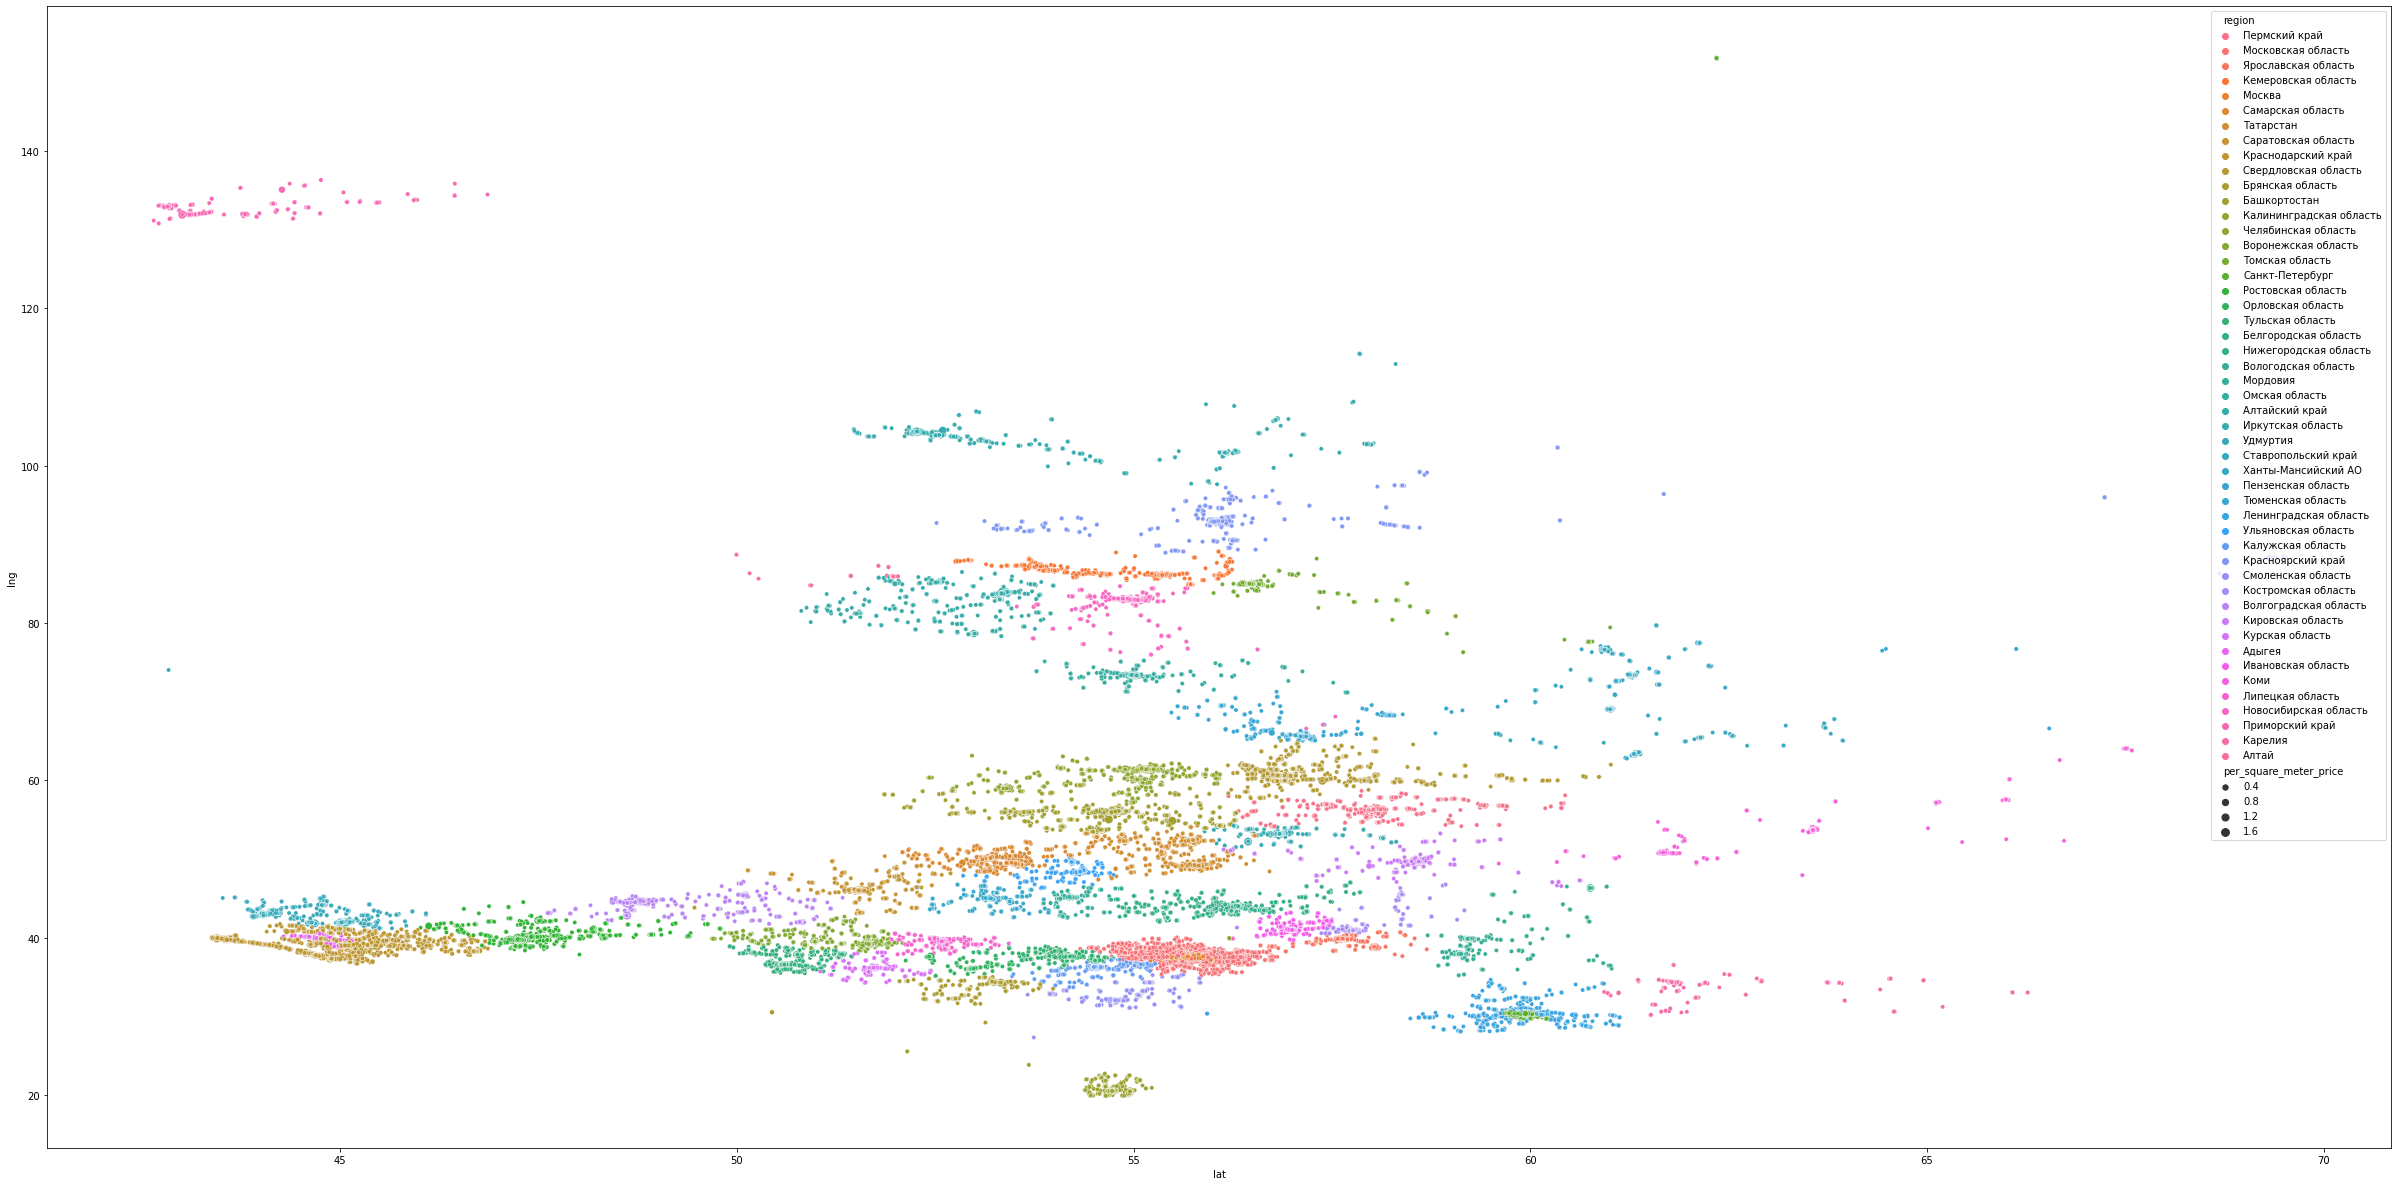

In [11]:
fig, ax = plt.subplots(1, figsize=(42,21))

sns.scatterplot(data=df, x='lat', y='lng', size='per_square_meter_price', hue='region', ax=ax)

In [85]:
transformed_df = df.copy()
transformed_df['per_square_meter_price'] = df['per_square_meter_price'].apply(np.log)
transformed_df['total_square'] = df['total_square'].apply(np.log)
transformed_df['osm_catering_points_in_0.001'] = df['osm_catering_points_in_0.001'].apply(np.log)

<AxesSubplot:xlabel='per_square_meter_price', ylabel='Proportion'>

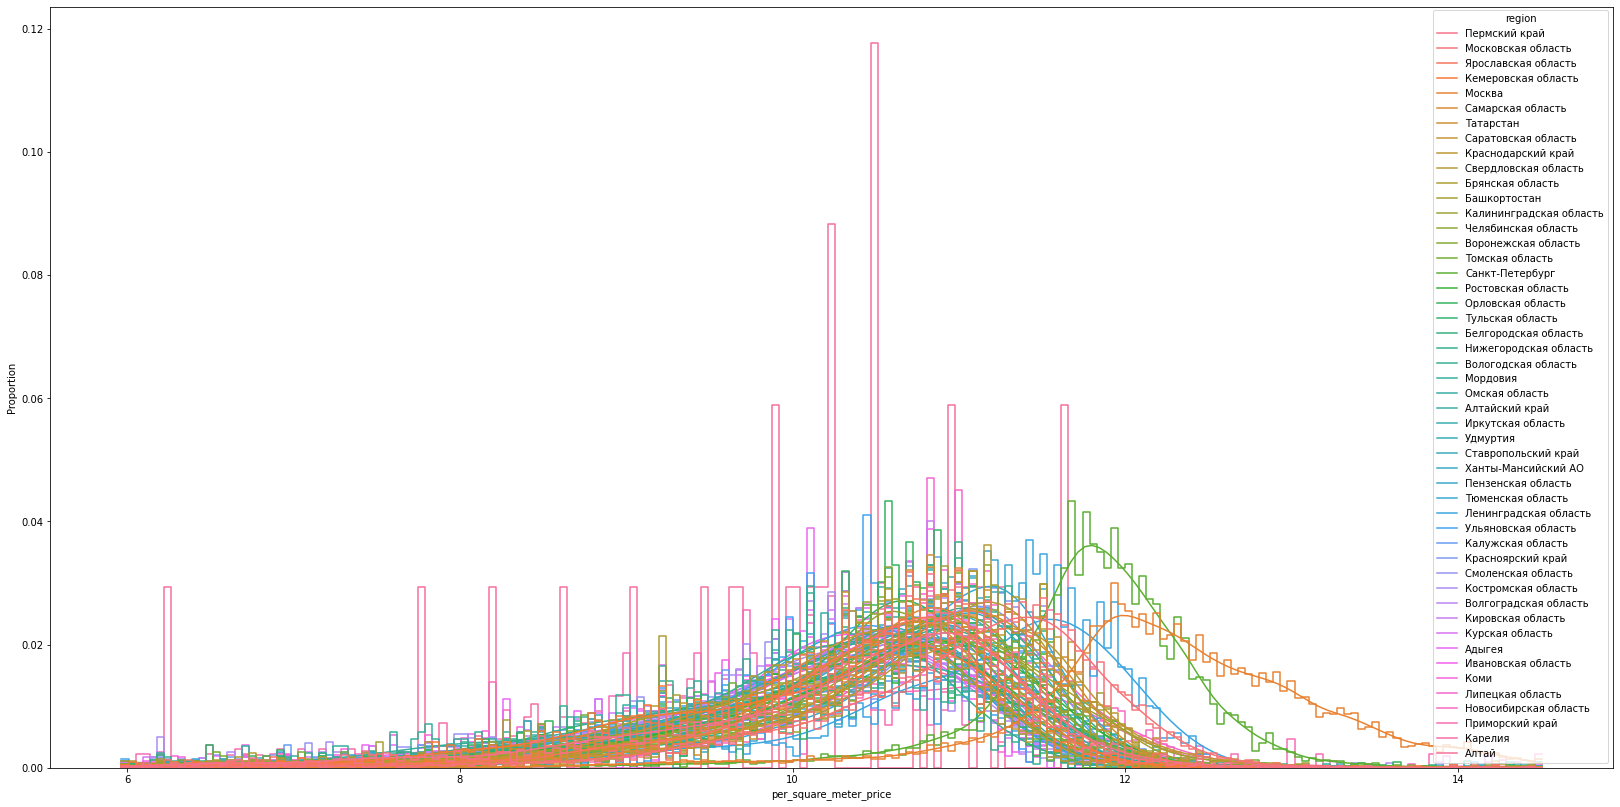

In [62]:
fig, ax = plt.subplots(1, figsize=(28,14))
sns.histplot(data=transformed_df, x='per_square_meter_price', hue='region',
             element="step", fill=False, kde=True, common_norm=False, stat='proportion', ax=ax)

Вывод: регион влияет на цену за квадратный метр

<AxesSubplot:xlabel='per_square_meter_price', ylabel='Proportion'>

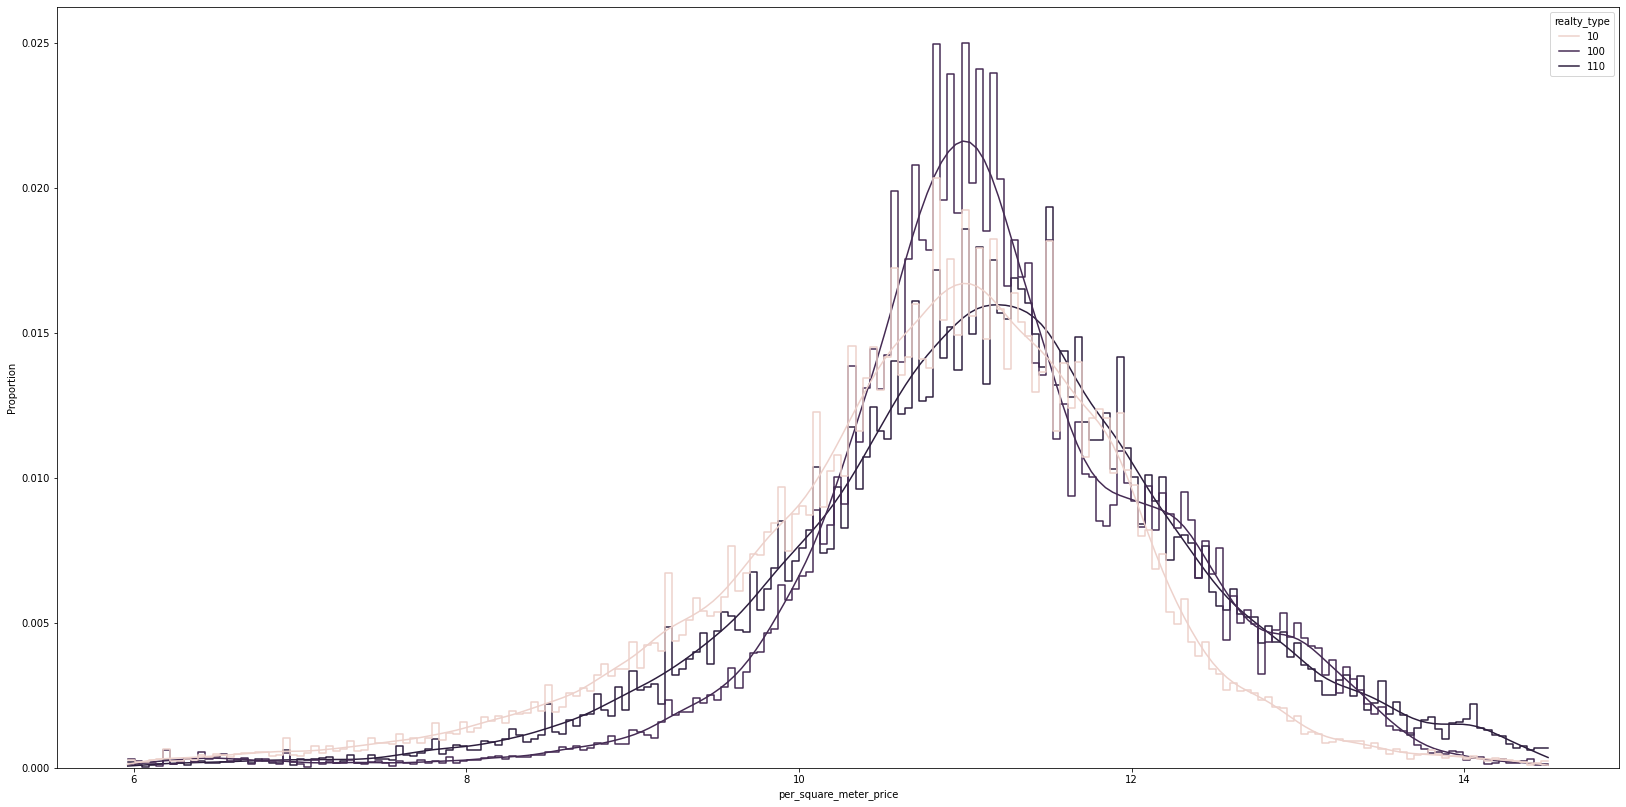

In [80]:
fig, ax = plt.subplots(1, figsize=(28,14))
sns.histplot(data=transformed_df, x='per_square_meter_price', hue='realty_type',
             element="step", fill=False, kde=True, common_norm=False, stat='proportion', ax=ax)

Вывод: тип недвижимости мало влияет на цену за квадратный метр

<AxesSubplot:xlabel='total_square', ylabel='Proportion'>

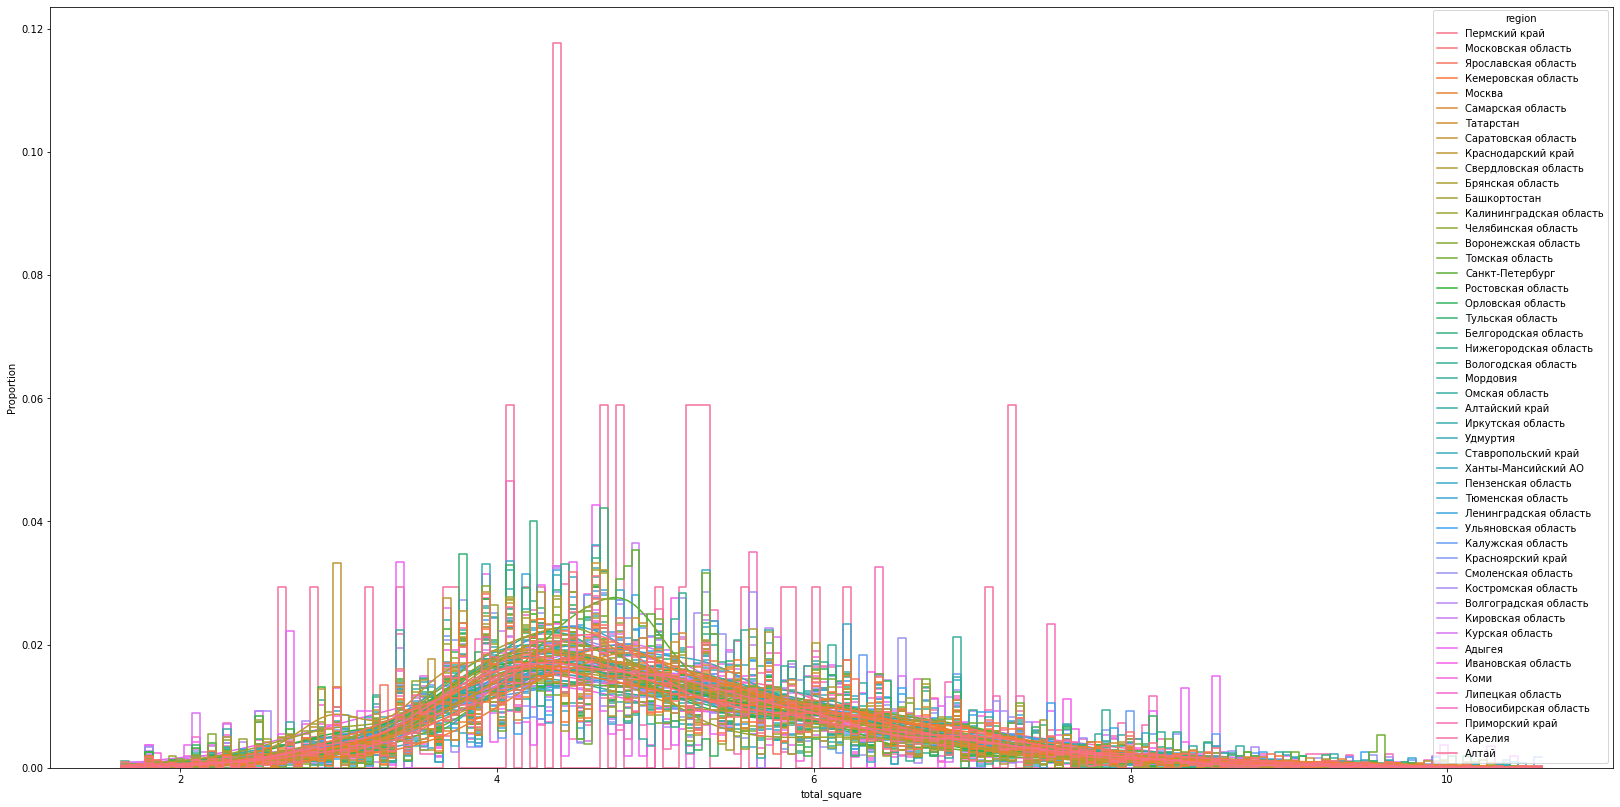

In [81]:
fig, ax = plt.subplots(1, figsize=(28,14))
sns.histplot(data=transformed_df, x='total_square', hue='region', element="step", fill=False, 
             kde=True, common_norm=False, stat='proportion', ax=ax)

Вывод: регион не влияет на размер помещений

<AxesSubplot:xlabel='total_square', ylabel='Proportion'>

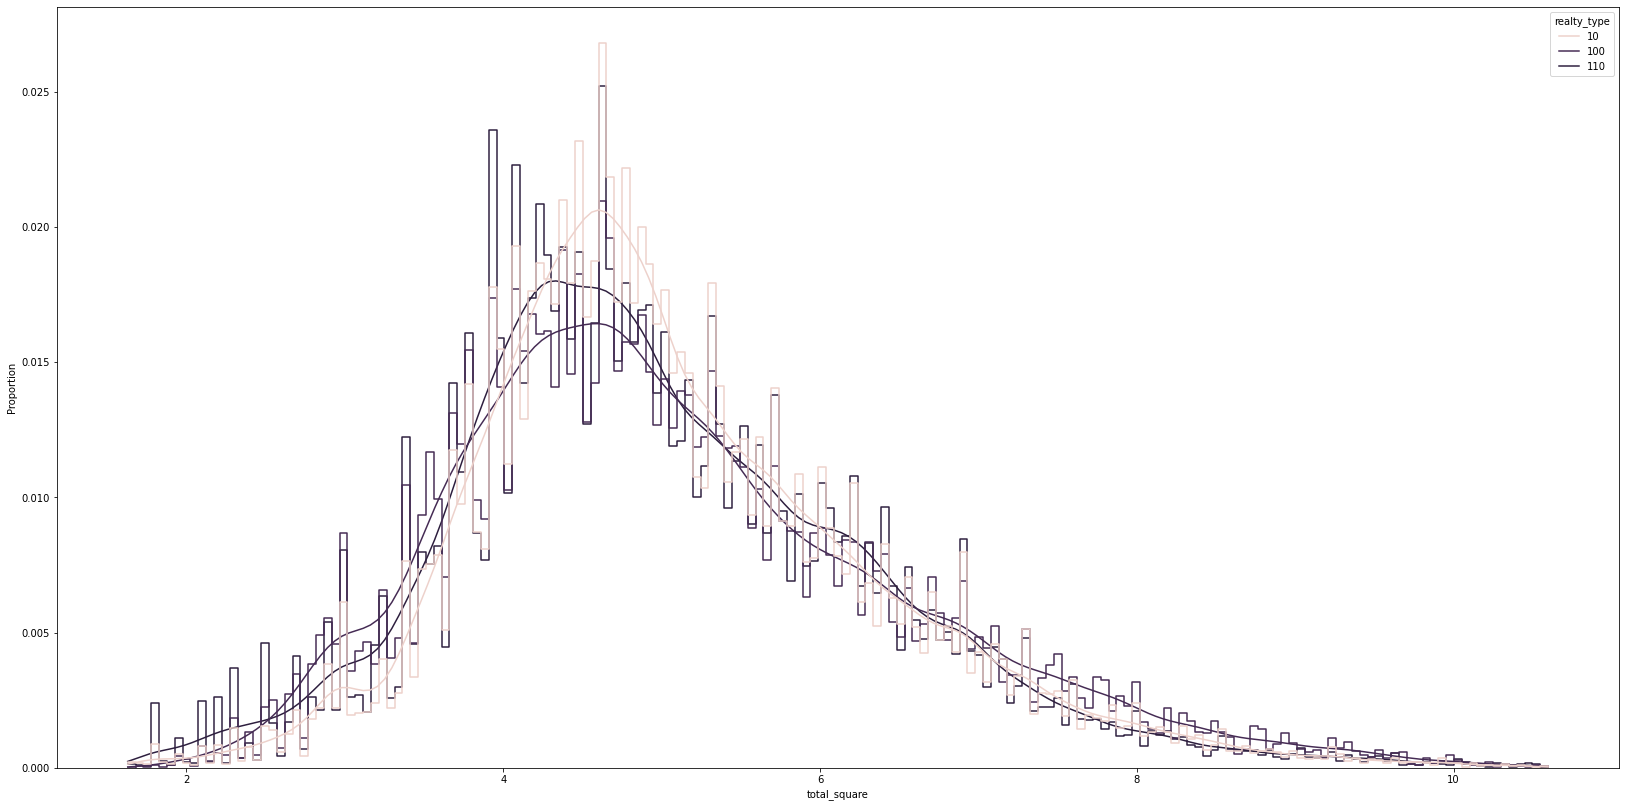

In [82]:
fig, ax = plt.subplots(1, figsize=(28,14))
sns.histplot(data=transformed_df, x='total_square', hue='realty_type', element="step", fill=False, 
             kde=True, common_norm=False, stat='proportion', ax=ax)

Вывод: тип недвижимости не влияет на размер помещений

<AxesSubplot:xlabel='osm_catering_points_in_0.001', ylabel='Proportion'>

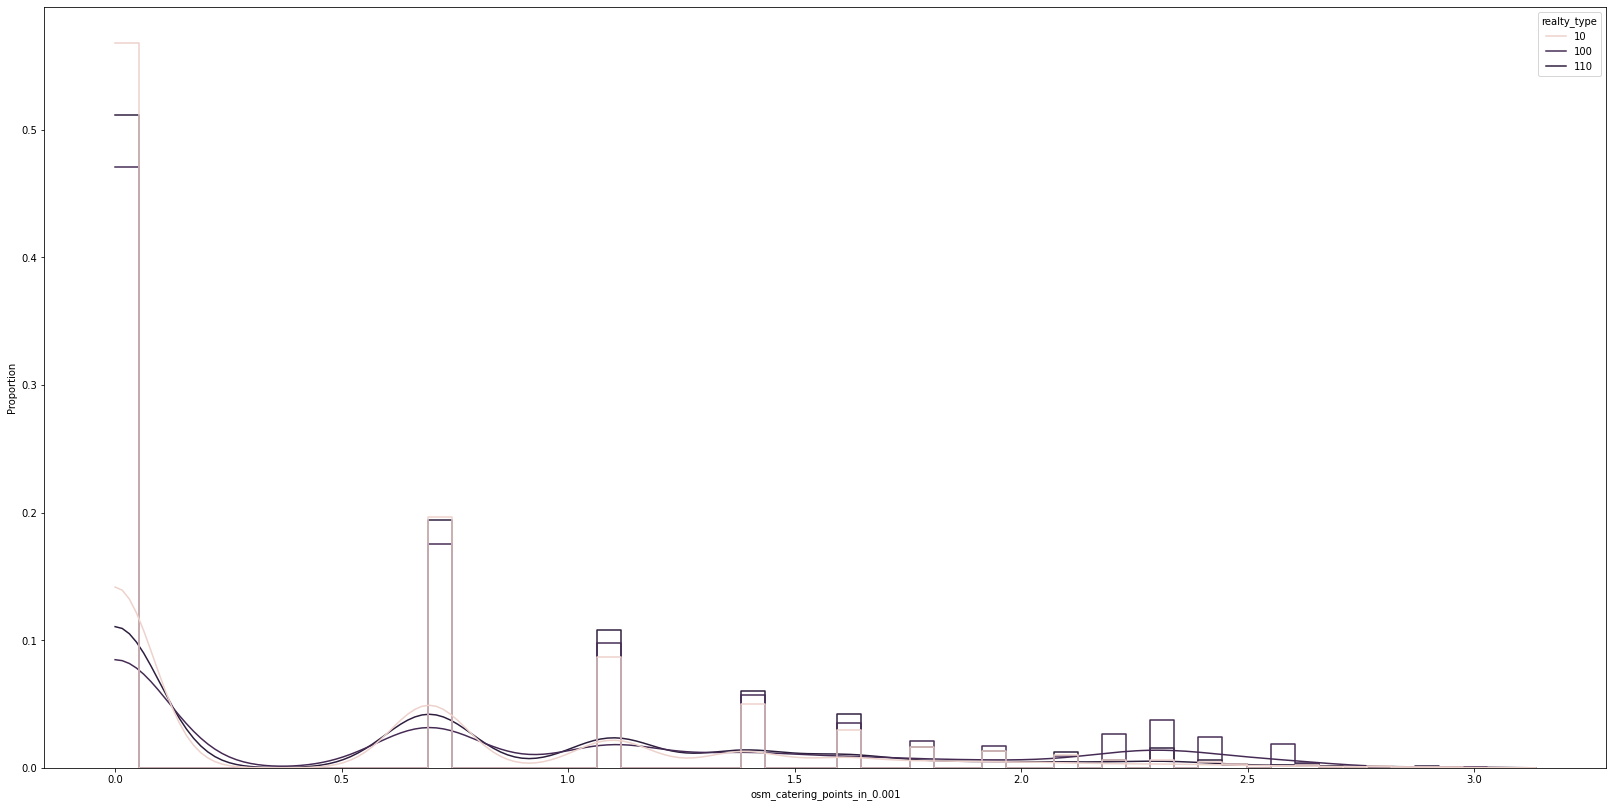

In [86]:
fig, ax = plt.subplots(1, figsize=(28,14))
sns.histplot(data=transformed_df, x='osm_catering_points_in_0.001', hue='realty_type', element="step", fill=False, 
             kde=True, common_norm=False, stat='proportion', ax=ax)

<AxesSubplot:xlabel='total_square', ylabel='per_square_meter_price'>

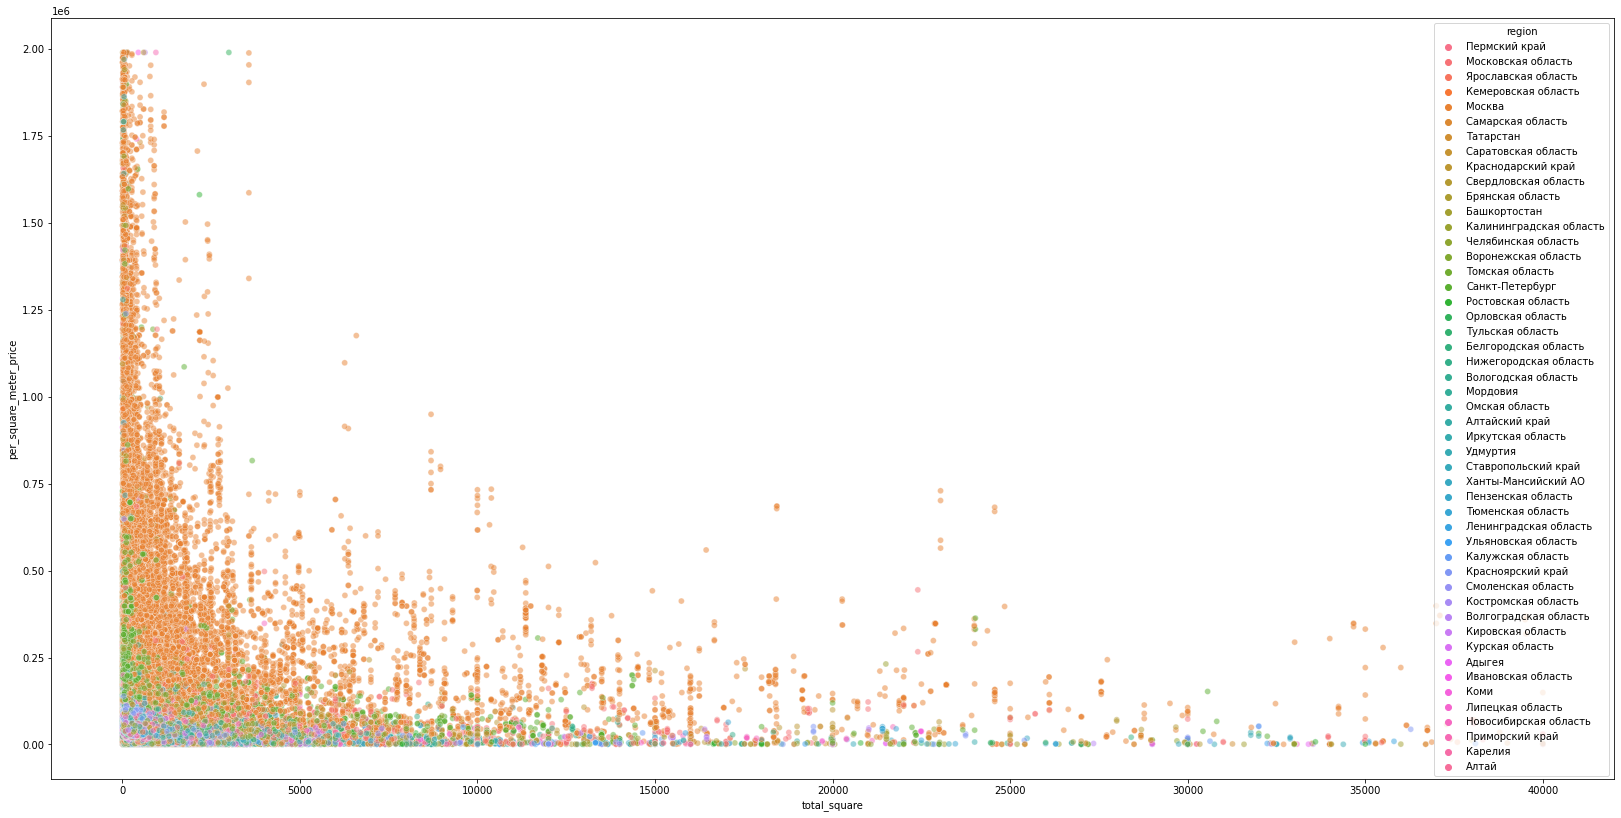

In [74]:
idx = df['total_square'] > 0
fig, ax = plt.subplots(1, figsize=(28,14))
sns.scatterplot(data=df[idx], x='total_square', y='per_square_meter_price', hue='region', alpha=0.5, ax=ax)

Вывод: чем больше площадь помещения, тем ниже цена за квадратный метр

<AxesSubplot:xlabel='lng', ylabel='osm_catering_points_in_0.001'>

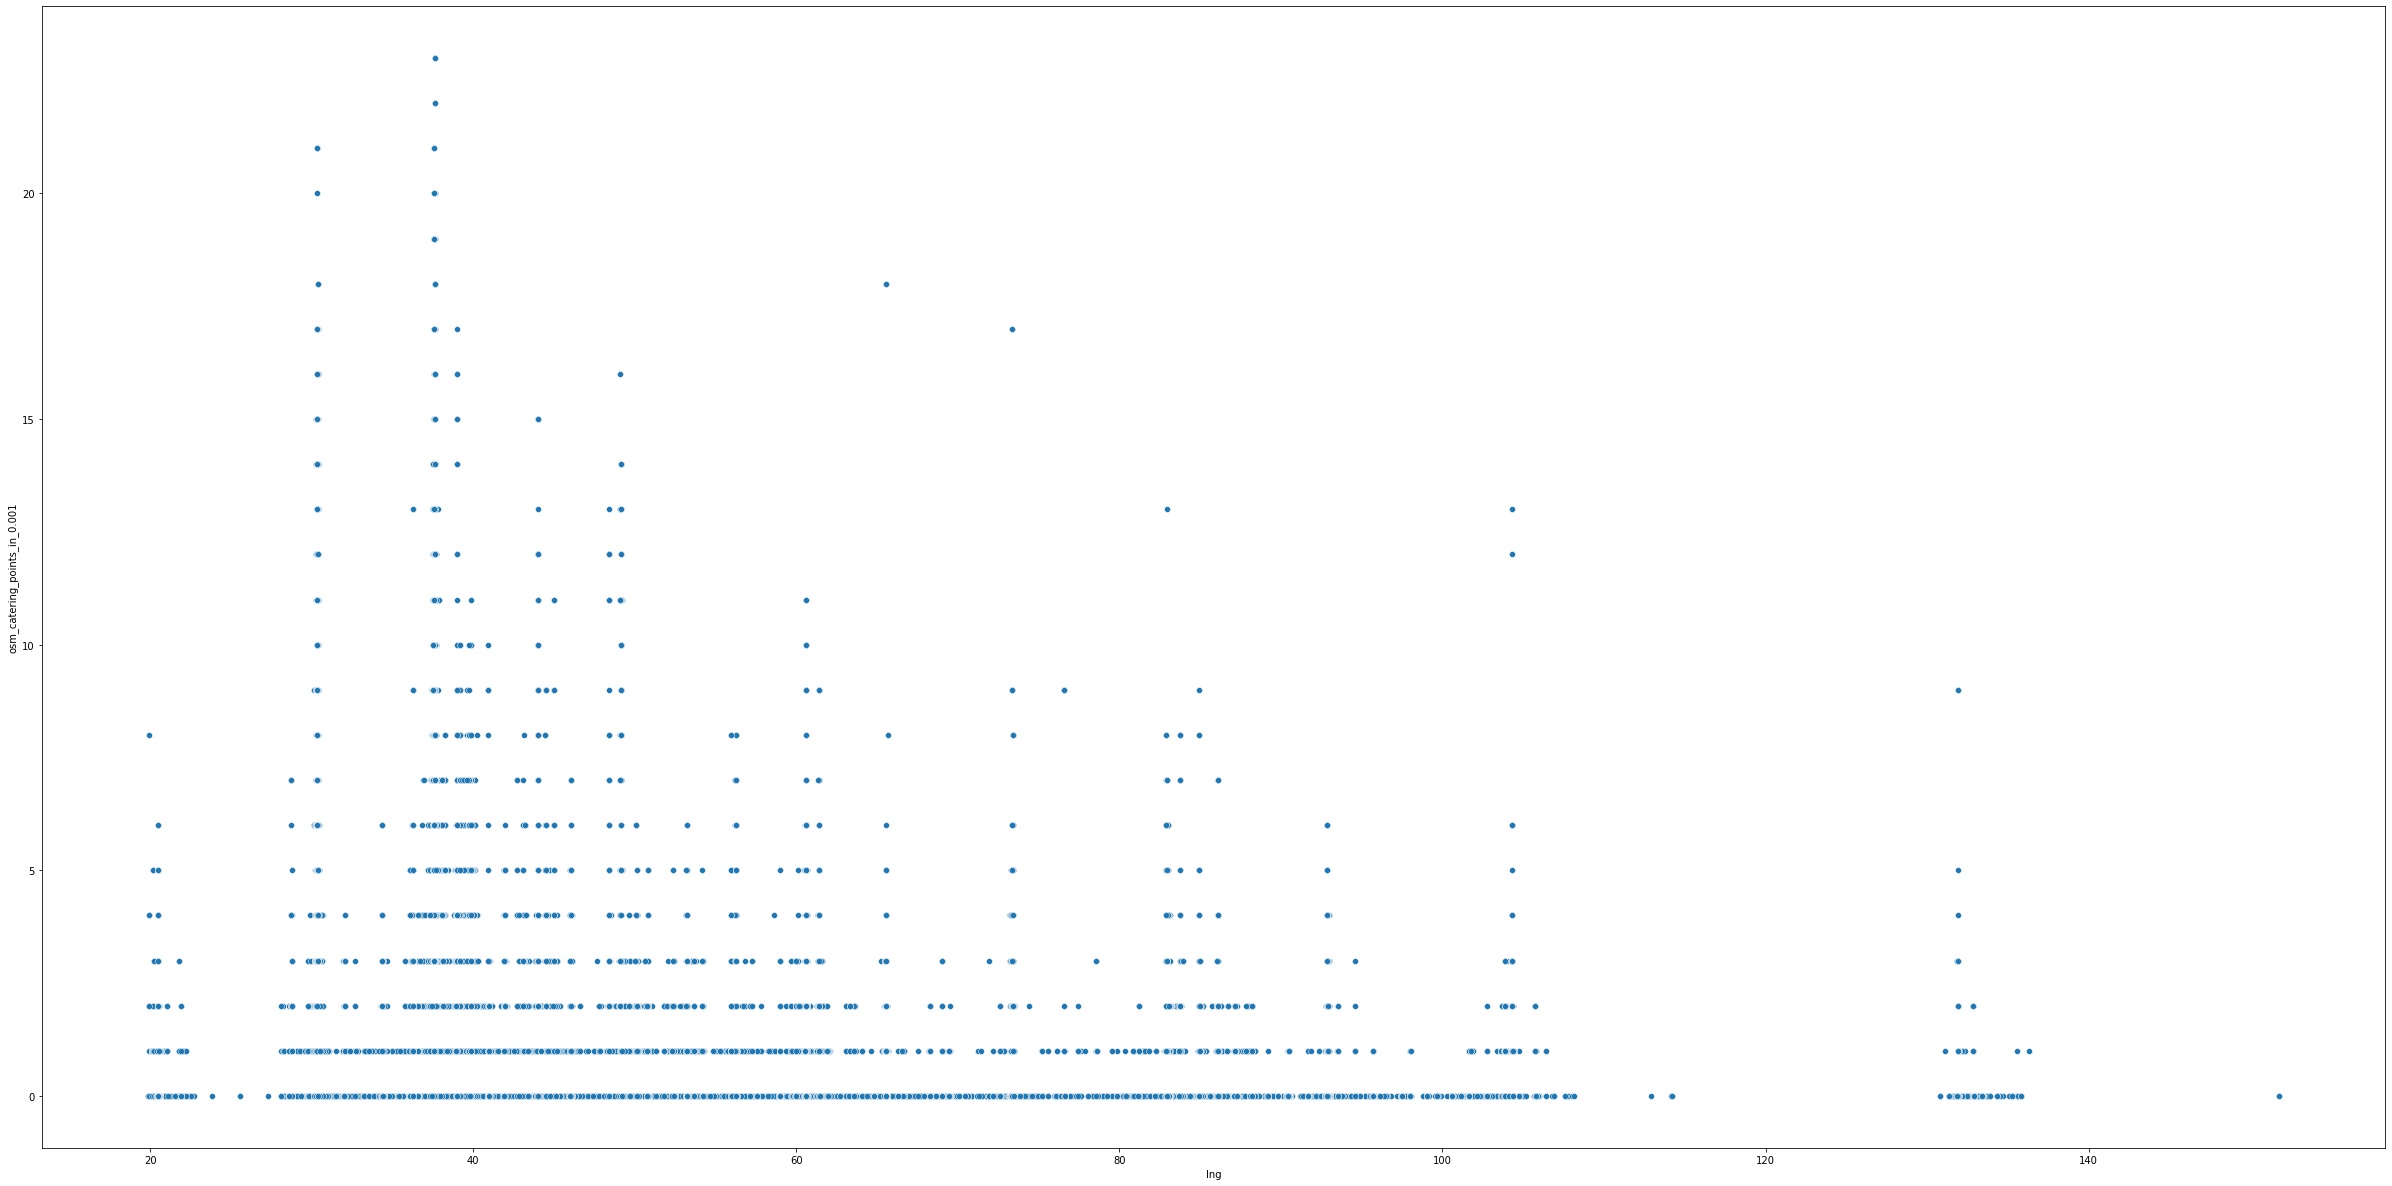

In [79]:
fig, ax = plt.subplots(1, figsize=(42,21))

sns.scatterplot(data=df, x='lng', y='osm_catering_points_in_0.001', ax=ax)

In [416]:
target_column = 'per_square_meter_price'
target = df[target_column]
df = df[[c for c in df.columns if c != target_column]]

In [417]:
list(df.columns)

['city',
 'floor',
 'id',
 'lat',
 'lng',
 'osm_amenity_points_in_0.001',
 'osm_amenity_points_in_0.005',
 'osm_amenity_points_in_0.0075',
 'osm_amenity_points_in_0.01',
 'osm_building_points_in_0.001',
 'osm_building_points_in_0.005',
 'osm_building_points_in_0.0075',
 'osm_building_points_in_0.01',
 'osm_catering_points_in_0.001',
 'osm_catering_points_in_0.005',
 'osm_catering_points_in_0.0075',
 'osm_catering_points_in_0.01',
 'osm_city_closest_dist',
 'osm_city_nearest_name',
 'osm_city_nearest_population',
 'osm_crossing_closest_dist',
 'osm_crossing_points_in_0.001',
 'osm_crossing_points_in_0.005',
 'osm_crossing_points_in_0.0075',
 'osm_crossing_points_in_0.01',
 'osm_culture_points_in_0.001',
 'osm_culture_points_in_0.005',
 'osm_culture_points_in_0.0075',
 'osm_culture_points_in_0.01',
 'osm_finance_points_in_0.001',
 'osm_finance_points_in_0.005',
 'osm_finance_points_in_0.0075',
 'osm_finance_points_in_0.01',
 'osm_healthcare_points_in_0.005',
 'osm_healthcare_points_in_0.

In [482]:
# df = df[[c for c in df.columns if c != 'street']]

In [481]:
# Разделим данные на категории
categorical_features = ['price_type', 'realty_type', 'region', 'city', 'osm_city_nearest_name']  # 'street', 
numerical_features = [c for c in df.columns if c not in categorical_features]

In [420]:
df[[c for c in df[categorical_features] if df[c].dtype != 'O']] += 1
df.replace(np.nan, 0, inplace=True)

In [421]:
# Отфильтруем данные по значениям целевой переменной
target_threshold = np.quantile(target.to_numpy(), 0.95)
filter_idx = np.where(target.to_numpy() < target_threshold)
target = target.iloc[filter_idx].reset_index(drop=True)
df = df.iloc[filter_idx].reset_index(drop=True)

In [422]:
# fig, ax = plt.subplots(1, figsize=(28,14))
# target[target < target_threshold].plot(ax=ax, ls='', marker='.', alpha=0.5)  # .hist(ax=ax)
# target.plot(ax=ax, ls='', marker='.', alpha=0.5)  # .hist(ax=ax, alpha=0.7)

In [423]:
# Не проканало особо
# # Вычислить число заведений в каждой из зон

# facilities_in_raduis_columns = [c for c in df.columns if ('osm' in c and 'points' in c)]
# category_names = np.unique([c.split('_in_')[0] for c in facilities_in_raduis_columns])
# category_column_names = [[c for c in facilities_in_raduis_columns if category_name in c] for category_name in category_names]
# tmp = []
# for columns in category_column_names:
#     columns = list(reversed(columns))
# #     facilities_num = df[columns]
#     for i in range(len(columns) - 1):
#         facilities_per_zone_num = df[columns[i]] - df[columns[i + 1]]
#         df[columns[i]] = facilities_per_zone_num

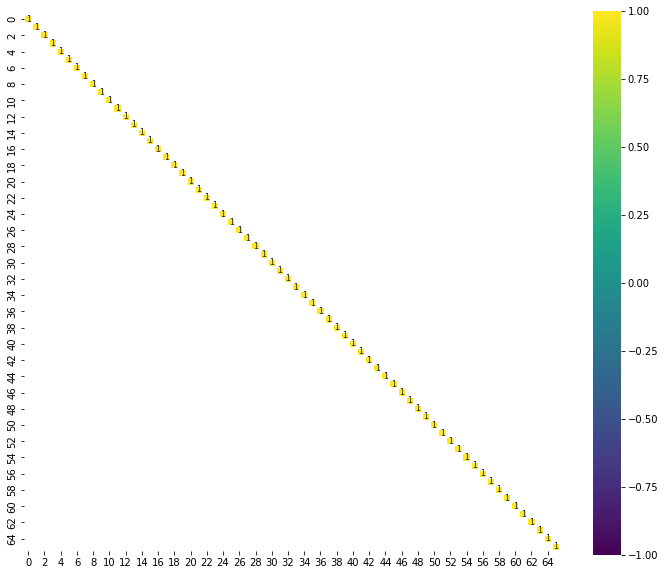

In [447]:
# Пробую PCA по фану
pca = PCA(n_components='mle')
pca_res = pca.fit_transform(df[numerical_features].to_numpy())
pca_res = pd.DataFrame(data=a, columns=list(range(a.shape[1])))

corr = pca_res.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [449]:
df = df[[c for c in df.columns if c not in numerical_features]]
df = pd.concat([df, pca_res], axis=1)

In [476]:
# idx = df[categorical_features].select_dtypes('O') == 0
# df[idx].replace(0, 'Missing', inplace=True)

In [484]:
encoder = OrdinalEncoder()
print((df[categorical_features].select_dtypes('O') == 0).astype(int).sum())
df[categorical_features] = encoder.fit_transform(df[categorical_features])

region                   0
city                     0
osm_city_nearest_name    0
dtype: int64


C:\Users\KONSTA~1\AppData\Local\Temp/ipykernel_9164/1307016445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_features] = encoder.fit_transform(df[categorical_features])
C:\Users\Konstantin\.virtualenvs\bd_ml_itmo-1eel-7OV\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [489]:
x_train, x_val, y_train, y_val = train_test_split(df.to_numpy(), target.to_numpy())

In [491]:
gb = GradientBoostingRegressor()
gb.fit(x_train, y_train)

GradientBoostingRegressor()

In [493]:
y_hat_train = gb.predict(x_train)
y_hat_val = gb.predict(x_val)

In [494]:
deviation_metric(y_train, y_hat_train)

3.9223240689393664

In [495]:
deviation_metric(y_val, y_hat_val)

3.950736799330586

In [499]:
#Save
OBJECTS_FOLDER = 'object'
if not os.path.exists(OBJECTS_FOLDER):
    os.mkdir(OBJECTS_FOLDER)
joblib.dump(encoder, os.path.join(OBJECTS_FOLDER, 'encoder.gzip'))
joblib.dump(gb, os.path.join(OBJECTS_FOLDER, 'gb.gzip'))
joblib.dump(pca, os.path.join(OBJECTS_FOLDER, 'pca.gzip'))

['object\\pca.gzip']